# Principal Component Analysis (PCA)

Principal Component Analysis (PCA) ou Análise dos Componentes Principais, é uma técnica de transformação linear simples, porém popular e útil, que é usada em inúmeras aplicações, como previsões de mercado de ações, análise de dados de expressão de genes e muito mais. Nesta aula, veremos que o PCA não é apenas uma “caixa preta”, e vamos desvendar seu mecanismo operacioanl em etapas básicas.

## Introdução

O tamanho dos dados na era moderna não é apenas um desafio para o hardware, mas também é um gargalo principal para o desempenho de muitos algoritmos de aprendizado de máquina. O principal objetivo de uma análise utilizando PCA é identificar padrões nos dados.

O PCA tem como objetivo detectar a correlação entre as variáveis, se existe uma forte correlação entre as variáveis, é possível utilizar o PCA na tentativa de reduzir a dimensionalidade dos dados.

Em suma, é disso que se trata o PCA: encontrar as direções de máxima variação em dados de alta dimensão e projetá-los em um subespaço dimensional menor, mantendo a maior parte das informações.

## PCA e Redução de Dimensionalidade

Freqüentemente, o objetivo desejado é reduzir as dimensões de um conjunto de dados d-dimensional, projetando-o em um subespaço (k)-dimensional (onde k < d), afim de aumentar a eficiência computacional, mantendo a maior parte da informação. Uma questão importante é "qual é o tamanho de k que "melhor representa" os dados

Mais tarde, iremos calcular os autovetores (os componentes principais) de um conjunto de dados e armazená-los em uma matriz de projeção. Cada um desses autovetores está associado a um autovalor que pode ser interpretado como “comprimento” ou “magnitude” do autovetor correspondente. Se alguns autovalores tiverem uma magnitude significativamente maior do que outros, é possível realizar a redução do da dimensão do onjunto de dados via PCA para um subespaço dimensional menor.

## Sumário da Abordagem do PCA

- Normalize os dados.
- Obtenha os autovetores e os autovalores da matriz de covariância ou da matriz de correlação, ou execute a decomposição vetorial singular.
- Classifique os autovalores em ordem decrescente e escolha os k autovetores que correspondem aos k maiores autovalores, em que k é o número de dimensões do novo subespaço de recursos (k ≤ d).
- Construa a matriz de projeção W a partir dos autovetores k selecionados.
- Transformar o conjunto de dados original X por meio de W para obter um subespaço de características k dimensional Y.

## Preparando a base de Dados

Para essa aula, trabalharemos com o famoso conjunto de dados "Iris" que pode ser encontrado no repositório de aprendizado de máquina da UCI (https://archive.ics.uci.edu/ml/datasets/Iris).

O conjunto de dados da íris contém medições para 150 flores de íris de três espécies diferentes.

As três classes no conjunto de dados Iris são:

- Iris-setosa (n = 50)
- Íris-versicolor (n = 50)
- Iris-virginica (n = 50)

E as quatro variáves do conjunto de dados são:

- comprimento de sépala em cm
- largura da sépala em cm
- comprimento da pétala em cm
- largura da pétala em cm

<img src="iris.png" />

## Carregando a Base de Dados

Para carregar os dados da Iris diretamente do repositório da UCI, vamos usar a biblioteca de pandas.

In [1]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True) # drops the empty line at file-end

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [4]:
X = df.iloc[:, 0:4].values
y = df.iloc[:, 4].values

## Visualização de Dados Exploratória

Para ter uma ideia de como as 3 classes de flores diferentes são distribuídas ao longo das 4 características diferentes, vamos visualizá-las através de histogramas.

In [5]:
%matplotlib inline

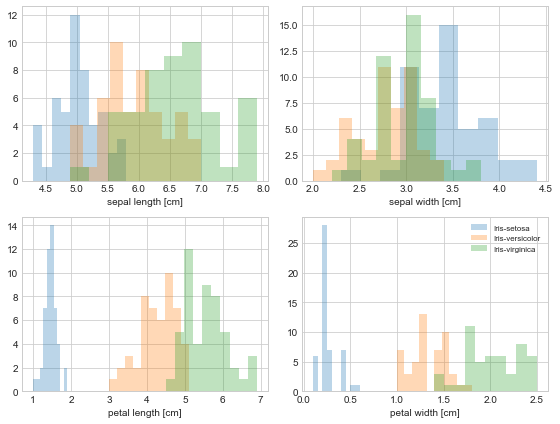

In [6]:
from matplotlib import pyplot as plt
import numpy as np
import math

label_dict = {1: 'Iris-Setosa',
              2: 'Iris-Versicolor',
              3: 'Iris-Virgnica'}

feature_dict = {0: 'sepal length [cm]',
                1: 'sepal width [cm]',
                2: 'petal length [cm]',
                3: 'petal width [cm]'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 6))
    for cnt in range(4):
        plt.subplot(2, 2, cnt+1)
        for lab in ('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=10,
                     alpha=0.3,)
        plt.xlabel(feature_dict[cnt])
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()

## Normalização dos Dados

A normalização dos dados antes da aplicação PCA na matriz de covariância depende das escalas das variáveis. Como o PCA produz um subespaço de vetorial que maximiza a variância ao longo dos eixos, é razoável normalizar os dados, especialmente se eles estão em escalas diferentes.

Embora todos as variáveis do conjunto de dados Iris tenham sido medidas em centímetros, continuamos com a transformação dos dados em escala unitária (média = 0 e variância = 1), o que é um requisito para o desempenho ideal de muitos algoritmos de aprendizado de máquina.

In [7]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

# 1. Autodecomposição - Calculando Auto-Valores e Auto-Vetores

Os autovetores e autovalores de uma matriz de covariância (ou correlação) representam o “núcleo” de um PCA: os autovetores (componentes principais) determinam as direções do novo espaço de característica, e os autovalores determinam sua magnitude. Em outras palavras, os autovalores explicam a variância dos dados ao longo dos novos eixos do recurso.

## 1.1 Matriz de Covariância

A abordagem clássica para o PCA é realizar a eigendecomposição na matriz de covariância Σ, que é uma matriz d × d onde cada elemento representa a covariância entre duas variáveis

In [8]:
import numpy as np
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
print('Covariance matrix \n%s' %cov_mat)

Covariance matrix 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


De maneira mais simples, poderíamos utilizar a biblioteca numpy

In [10]:
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


Em seguida, realizamos uma auto-decomposição na matriz de covariância:

In [11]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.93035378 0.92740362 0.14834223 0.02074601]


## 1.2 Matriz de Correlação

Especialmente, no campo de "Finanças", a matriz de correlação normalmente é usada em vez da matriz de covariância. No entanto, a auto-decomposição da matriz de covariância (se os dados de entrada foram normalizados) produz os mesmos resultados que uma auto-decomposição na matriz de correlação não normalizada, uma vez que a matriz de correlação pode ser entendida como a matriz de covariância normalizada.

• Auto-decomposição dos dados padronizados com base na matriz de correlação:

In [12]:
cor_mat1 = np.corrcoef(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat1)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.91081808 0.92122093 0.14735328 0.02060771]


• Auto-decomposição dos dados não normalizados com base na matriz de correlação:

In [13]:
cor_mat2 = np.corrcoef(X.T)

eig_vals, eig_vecs = np.linalg.eig(cor_mat2)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]

Eigenvalues 
[2.91081808 0.92122093 0.14735328 0.02060771]


Podemos ver claramente que todas as três abordagens produzem os mesmos autovetores e pares de autovalores:

- Auto-decomposição da matriz de covariância após normalização dos dados.
- Auto-decomposição da matriz de correlação.
- Auto-decomposição da matriz de correlação após a normalização dos dados.

## 1.3 Decomposição Vetorial Singular

Enquanto a Auto-decomposição da matriz covariância ou matriz de correlação pode ser mais intuitiva, a maioria das implementações do PCA executam uma SVD (Singular Vector Decomposition - Decomposição Vetorial Singular) para melhorar a eficiência computacional. Então, vamos realizar um SVD para confirmar que o resultado é realmente o mesmo:

In [15]:
u,s,v = np.linalg.svd(X_std.T)
u

array([[-0.52237162, -0.37231836,  0.72101681,  0.26199559],
       [ 0.26335492, -0.92555649, -0.24203288, -0.12413481],
       [-0.58125401, -0.02109478, -0.14089226, -0.80115427],
       [-0.56561105, -0.06541577, -0.6338014 ,  0.52354627]])

# 2. Selecionando os componentes principais

## 2.1 Ordenando os Auto-Pares

O objetivo típico de um PCA é reduzir a dimensionalidade do espaço de variáveis original projetando-o em um subespaço menor, onde os autovetores formarão os eixos. No entanto, os autovetores definem apenas as direções do novo eixo, uma vez que possuem o mesmo comprimento de unidade 1, o que pode ser confirmado pelas duas linhas de código a seguir:

In [16]:
for ev in eig_vecs.T:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

Para decidir qual(is) autovetor(es) podem ser descartado sem perda de muita informação para a construção do subespaço de menor dimensão, precisamos inspecionar os autovalores correspondentes: Os autovetores com os menores autovalores possuem a menor informação sobre a distribuição dos dados; esses são os que podem ser descartados.

Para fazer isso, a abordagem comum é ordenar os autovalores do maior para o menor, a fim de escolher os autovetores k principais.

In [17]:
# Faça uma lista de tuplas (autovalor, autovetor)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Ordene essa lista em ordem decrescente (do maior para o menor) usando os autovalores como referencia
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
2.9108180837520528
0.9212209307072254
0.1473532783050958
0.020607707235624842


## 2.2 Variância Acumulada

Depois de ordenar os pares, a próxima pergunta é “quantos componentes principais vamos escolher para o nosso novo subespaço de variáveis?” Uma medida útil é a chamada “variância acumulada”, que pode ser calculada a partir dos autovalores. A variância acumulada nos diz quanta informação (variância) pode ser atribuída a cada um dos componentes principais.

In [18]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

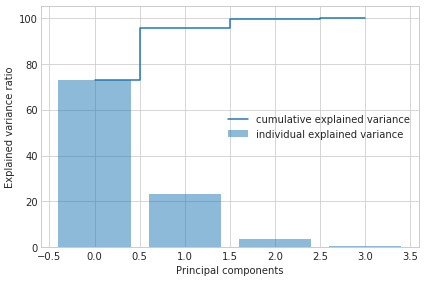

In [19]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

O gráfico acima mostra claramente que a maior parte da variância (72,77% da variância) está armazenada apenas no primeiro componente principal. O segundo componente principal ainda contém algumas informações (23,03%), enquanto o terceiro e quarto componentes principais podem ser descartados com segurança sem perder muita informação. Juntos, os dois primeiros componentes principais contêm 95,8% das informações.

## 2.3 Matriz de Projeção

É hora da parte realmente interessante: a construção da matriz de projeção que será usada para transformar os dados da Iris no novo subespaço de variáveis. O nome “matriz de projeção” pode parecer confuso, mas é basicamente apenas uma matriz dos nossos autovetores com k maiores autovalores, todos concatenados lado a lado.

Aqui, estamos reduzindo o espaço de variáveis 4-dimensional a um subespaço de variáveis bidimensional, escolhendo os autovetores “top 2” com os mais altos autovalores para construir nossa matriz de autovetores d × k-dimensional.

In [20]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4,1),
                      eig_pairs[1][1].reshape(4,1)))

print('Matrix W:\n', matrix_w)

('Matrix W:\n', array([[ 0.52237162, -0.37231836],
       [-0.26335492, -0.92555649],
       [ 0.58125401, -0.02109478],
       [ 0.56561105, -0.06541577]]))


# 3. Projeção no novo espaço de variáveis


Nesta última etapa, usaremos a matriz de projeção 4 × 2-dimensional W para transformar nossa base no novo subespaço através da equação.

Y = X × W, em que Y é uma matriz de 150 × 2 das nossas amostras transformadas.

In [21]:
Y = X_std.dot(matrix_w)

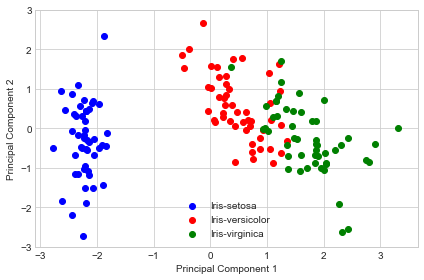

In [22]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

# PCA no scikit-learn

Para fins educacionais, percorremos um longo caminho para aplicar o PCA ao conjunto de dados Iris. Mas, felizmente, já existe implementação no scikit-learn.

In [23]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

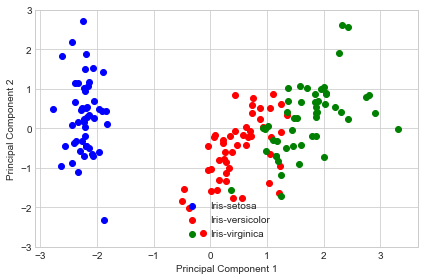

In [24]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'),
                        ('blue', 'red', 'green')):
        plt.scatter(Y_sklearn[y==lab, 0],
                    Y_sklearn[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()